In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#parameters
#size of patches
patch_size = 16
#number of patches to consider for pairwise matching
num_patches = 5
#number of frames (sampling rate)
num_frames = 64
#size of image and videos (to resize)
img_size = 256

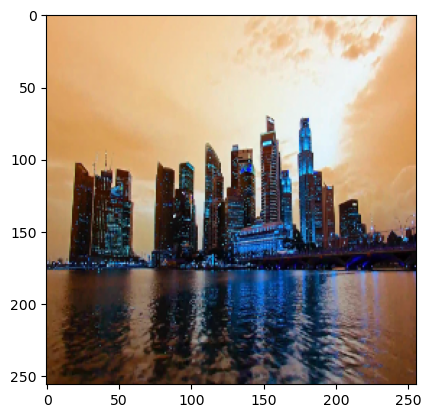

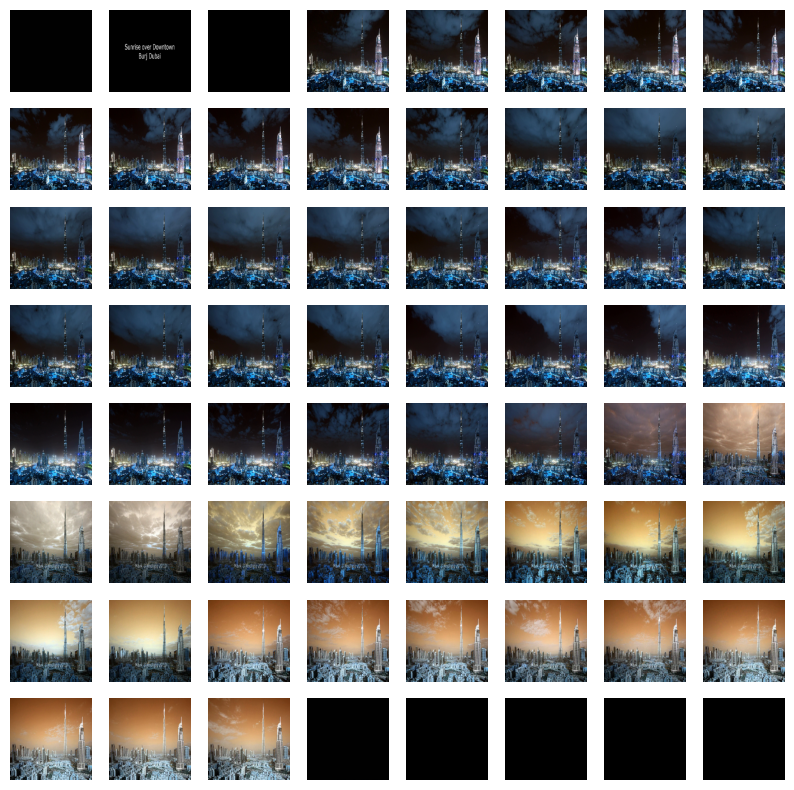

In [10]:
#load the image
img = cv2.imread('../data/images/singapore.jpg')
img = cv2.resize(img, (img_size, img_size))

#plot the image
plt.imshow(img)

#load the video
cap = cv2.VideoCapture('../data/videos/dubai.avi')

#load the video frames (num_frames) uniformly apart
frames = []
for i in range(num_frames):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i*(cap.get(cv2.CAP_PROP_FRAME_COUNT)-1)/(num_frames-1))
    ret, frame = cap.read()
    frame = cv2.resize(frame, (img_size, img_size))
    frames.append(frame)

#plot the frames 8x8 grid
fig, axs = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(frames[i*8+j])
        axs[i, j].axis('off')

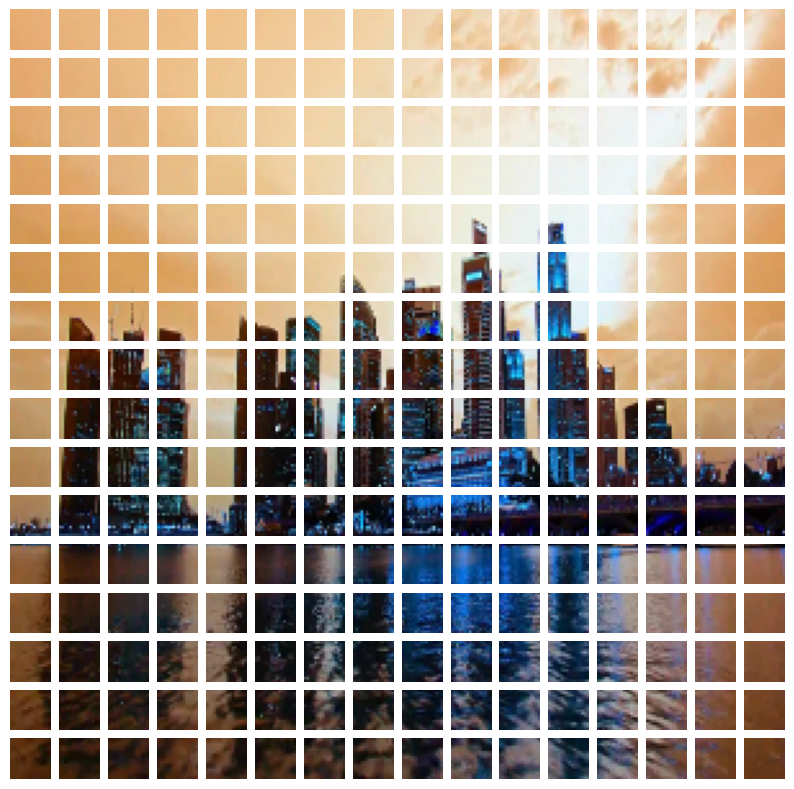

In [14]:
#convert image to patches
def img2patches(img, patch_size):
    patches = []
    for i in range(0, img.shape[0], patch_size):
        for j in range(0, img.shape[1], patch_size):
            patches.append(img[i:i+patch_size, j:j+patch_size])
    return patches

#plot the patches
patches = img2patches(img, patch_size)
fig, axs = plt.subplots(img_size//patch_size, img_size//patch_size, figsize=(10, 10))
for i in range(img_size//patch_size):
    for j in range(img_size//patch_size):
        axs[i, j].imshow(patches[i*img_size//patch_size+j])
        axs[i, j].axis('off')
      

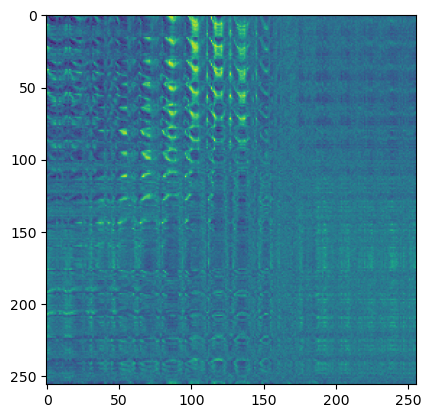

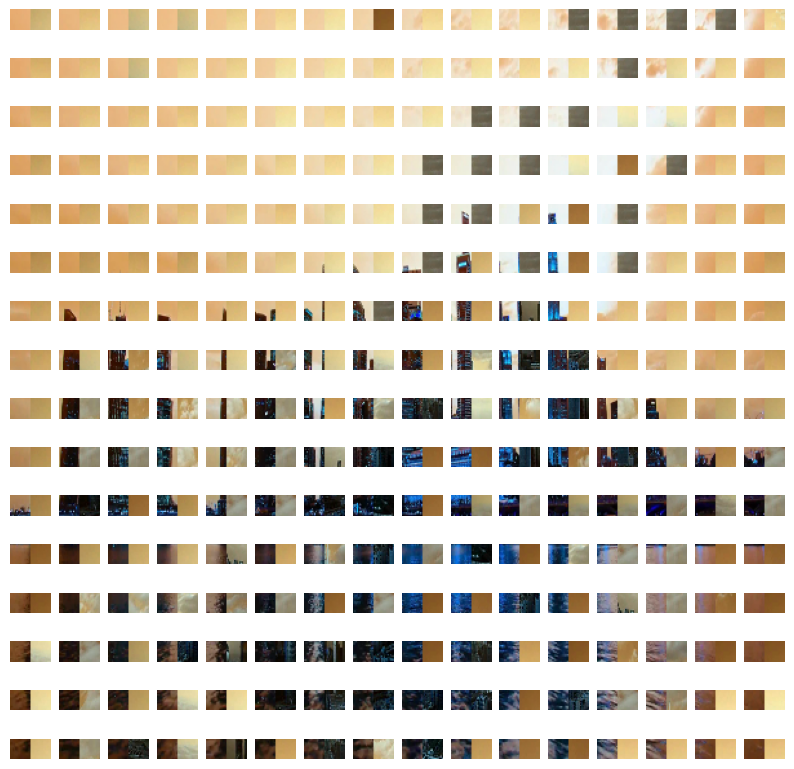

In [19]:
#local matching
#for the matched frame (47), we match each patch in the image with the patch in the frame that has the highest correlation
#for this we formulate the problem as a mrf having a data term and a pairwise term

#data term: we match each patch in the image with the patch in the frame that has the highest correlation using L2 norm  over square patches of size 2*patch_size+1

def data_term(img, frame, patch_size):
    #convert image and frame to patches
    img_patches = img2patches(img, patch_size)
    frame_patches = img2patches(frame, patch_size)
    #compute the data term
    data_term = np.zeros((len(img_patches), len(frame_patches)))
    for i in range(len(img_patches)):
        for j in range(len(frame_patches)):
            #compute the correlation
            data_term[i, j] = -np.sum(np.square(img_patches[i]-frame_patches[j]))
    return data_term, img_patches, frame_patches

#plot the data term
data_term, patches, frame_patches = data_term(img, frames[47], patch_size)
plt.imshow(data_term)

#plot the patch of the image alongside the patch of the frame that has the highest correlation for each patch in the image
fig, axs = plt.subplots(img_size//patch_size, img_size//patch_size, figsize=(10, 10))
for i in range(img_size//patch_size):
    for j in range(img_size//patch_size):
        axs[i, j].imshow(np.concatenate((patches[i*img_size//patch_size+j], frame_patches[np.argmax(data_term[i*img_size//patch_size+j])]), axis=1))
        axs[i, j].axis('off')


Best frame: 18


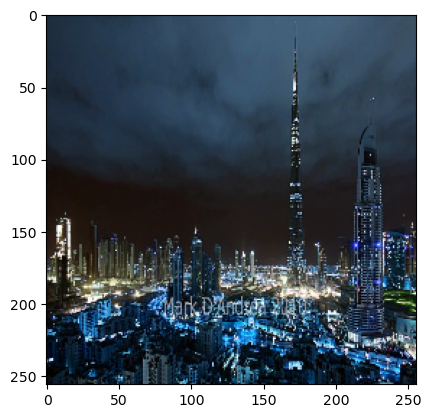

In [12]:
#find the best frame corresponding to the image and plot the result
best_frame = 0
best_data_term = np.inf
for i in range(num_frames):
    data_term_ij = data_term(img, frames[i], patch_size, num_patches)
    if np.sum(data_term_ij) < best_data_term:
        best_data_term = np.sum(data_term_ij)
        best_frame = i
print('Best frame: %d' % best_frame)
plt.figure()
plt.imshow(frames[best_frame])